# EMG Hand Gesture Classification

In [1]:
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import data_preprocessing as dp
import feature_engineering as fe
import model_selection as ms

from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout


### Reading Dataset

In [2]:
df = pd.read_csv("data.csv")
df

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,label
0,1,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0,1
1,5,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0,1
2,6,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0,1
3,7,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0,1
4,8,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0,1
...,...,...,...,...,...,...,...,...,...,...,...
4237902,50962,0.00001,-0.00001,-0.00002,-0.00004,-0.00012,0.00000,0.00002,0.00002,0,36
4237903,50963,0.00001,-0.00001,-0.00002,-0.00004,-0.00012,0.00000,0.00002,0.00002,0,36
4237904,50964,0.00001,-0.00001,-0.00002,-0.00004,-0.00012,0.00000,0.00002,0.00002,0,36
4237905,50965,0.00001,-0.00001,-0.00002,-0.00004,-0.00012,0.00000,0.00002,0.00002,0,36


### Dataset Preprocessing

In [3]:
apply_filter = True
X_df = dp.get_recording(df, apply_filter)

### Feature Selection

In [4]:
feature_flag = False

In [5]:
if feature_flag:
    models = [LogisticRegression(random_state=42),
            KNeighborsClassifier(),
            SVC(random_state=42),
            DecisionTreeClassifier(random_state=42),
            RandomForestClassifier(random_state=42)]

    accuracy, accuracy_var = [], []
    for f_idx in range(20):
        f_range = [f_idx]
        X, person_id, y = fe.extract_features_from_recordings(X_df, f_range)
        X = StandardScaler().fit_transform(X)
        gkf = GroupKFold(n_splits=36)
        cv_score, cv_score_var = [], []
        for model in models:
            cv_score.append(cross_val_score(model, X, y, cv=gkf, groups=person_id, scoring='accuracy'))
        accuracy.append(np.mean(cv_score))
        accuracy_var.append(np.var(cv_score))

In [6]:
if feature_flag:
    categories = ['MEAN', 'VAR', 'SKEW', 'KURTOSIS', 'MAV', 'AAC', 'ZC', 'RMS', 'SSC', 'AC1', 'AC2', 'AC3', 'AC4', 'CC1', 'CC2', 'CC3', 'CC4', 'MYPR', 'MF', 'MDF']
    for idx, (name, score, var) in enumerate(zip(categories, accuracy, accuracy_var)):
        print(f'{idx}. Accuracy Feature {name}: {score:.5f}±{var:.5f}')

    fig, ax = plt.subplots(figsize=(8, 4))
    plt.bar(categories, accuracy, yerr=accuracy_var, edgecolor='black')
    plt.xlabel('Features')
    plt.ylabel('Accuracy')
    plt.title('Analysing Feature Importance')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

In [7]:
if feature_flag:
    f_range = np.arange(0, 20, 1)
    X, person_id, y = fe.extract_features_from_recordings(X_df, f_range)
    decision_clf = DecisionTreeClassifier(random_state=42)
    decision_clf.fit(X, y)
    feature_importances = decision_clf.feature_importances_.reshape(8, 20)
    feature_tally = np.sum(np.where(feature_importances > 0, 1, 0), axis=0)

In [8]:
if feature_flag:
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.bar(categories, feature_tally, edgecolor='black')
    plt.xlabel('Features')
    plt.ylabel('Tally')
    plt.title('Analysing Feature Importance')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

In [9]:
feature_selection = [0, 1, 4, 5, 7, 8, 17, 19]
X, person_id, y = fe.extract_features_from_recordings(X_df, feature_selection)
print(f"Data shape: {X.shape}, Person ID shape: {person_id.shape}, Label shape: {y.shape}.")
y_oh = pd.get_dummies(y)
print(f'One Hot Label shape: {y_oh.shape}')

Data shape: (654, 64), Person ID shape: (654,), Label shape: (654,).
One Hot Label shape: (654, 7)


In [10]:
random.seed(42)
numbers = list(range(1, 37))
numbers.remove(30)
chosen_id = random.sample(numbers, 30)
unchosen_id = list(set(range(1, 37)) - set(chosen_id))
print(f'Unchosen Person ID: {unchosen_id}')

Unchosen Person ID: [33, 6, 10, 13, 21, 30]


In [11]:
apply_smothe_flag = False

In [12]:
# Training Set
X_train = X[np.isin(person_id, chosen_id)].astype(float) 
y_train = y[np.isin(person_id, chosen_id)]
y_oh_train = y_oh[np.isin(person_id, chosen_id)]
person_id_train = person_id[np.isin(person_id, chosen_id)]

# Testing Set
X_test = X[np.isin(person_id, unchosen_id)].astype(float) 
y_test = y[np.isin(person_id, unchosen_id)]
y_oh_test = y_oh[np.isin(person_id, unchosen_id)]
person_id_test = person_id[np.isin(person_id, unchosen_id)]

person_id_tile_train = person_id_train[:90]
person_id_tile_test = person_id_train[:18]
count_before_train = np.bincount(y_train.astype(int))
count_before_test = np.bincount(y_test.astype(int))

# Class Imbalance Set
if apply_smothe_flag:
    smote = SMOTE(random_state=42, k_neighbors=2)
    X_smote_train, y_smote_train = smote.fit_resample(X_train, y_train)
    X_smote = X_smote_train[-90:]
    y_smote = y_smote_train[-90:]
    X_reshuffle = np.vstack((X_smote[3:27], X_smote[:3], X_smote[27:]))
    y_reshuffle = np.hstack((y_smote[3:27], y_smote[:3], y_smote[27:]))
    X_train = np.vstack((X_smote_train[:-90], X_reshuffle))
    y_train = np.hstack((y_smote_train[:-90], y_reshuffle))
    person_id_train = np.hstack((person_id_train[:-3], person_id_tile_train))
    count_after_train = np.bincount(y_train.astype(int))

    smote = SMOTE(random_state=42, k_neighbors=2)
    X_smote_test, y_smote_test = smote.fit_resample(X_test, y_test)
    X_smote = X_smote_test[-18:]
    y_smote = y_smote_test[-18:]
    X_reshuffle = np.vstack((X_smote[3:], X_smote[:3]))
    y_reshuffle = np.hstack((y_smote[3:], y_smote[:3]))
    X_test = np.vstack((X_smote_test[:-18], X_reshuffle))
    y_test = np.hstack((y_smote_test[:-18], y_reshuffle))
    count_after_test = np.bincount(y_test.astype(int))

    # Data for the two bar plots
    categories = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7']
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].bar(categories, count_before_train[1:])
    axes[0].set_title('Before SMOTE')
    axes[0].set_xlabel('Classes')
    axes[0].set_ylabel('Number of Recordings')
    axes[0].tick_params(axis='x', rotation=45) 
    axes[0].grid()
    axes[1].bar(categories, count_after_train[1:])
    axes[1].set_title('After SMOTE')
    axes[1].set_xlabel('Classes')
    axes[1].tick_params(axis='x', rotation=45) 
    axes[1].grid()
    plt.suptitle('SMOTE Impact on Training Data')
    plt.tight_layout()
    plt.show()

    # Data for the two bar plots
    categories = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7']
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].bar(categories, count_before_test[1:])
    axes[0].set_title('Before SMOTE')
    axes[0].set_xlabel('Classes')
    axes[0].set_ylabel('Number of Recordings')
    axes[0].tick_params(axis='x', rotation=45) 
    axes[0].grid()
    axes[1].bar(categories, count_after_train[1:])
    axes[1].set_title('After SMOTE')
    axes[1].set_xlabel('Classes')
    axes[1].tick_params(axis='x', rotation=45) 
    axes[1].grid()
    plt.suptitle('SMOTE Impact on Testing Data')
    plt.tight_layout()
    plt.show()

# Scaling Sets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
X_cnn, person_id_cnn, y_cnn = fe.process_all_recordings(X_df, 256, 22)
print(X_cnn.shape)
y_cnn = np.array([int(label-1) for label in y_cnn])

# Training Set
X_cnn_train = X_cnn[np.isin(person_id_cnn, chosen_id)].astype(float) 
y_cnn_train = y_cnn[np.isin(person_id_cnn, chosen_id)]
y_oh_cnn_train = y_oh[np.isin(person_id_cnn, chosen_id)]
person_id_cnn_train = person_id_cnn[np.isin(person_id_cnn, chosen_id)]

# Testing Set
X_cnn_test = X_cnn[np.isin(person_id_cnn, unchosen_id)].astype(float) 
y_cnn_test = y_cnn[np.isin(person_id_cnn, unchosen_id)]
y_oh_cnn_test = y_oh[np.isin(person_id_cnn, unchosen_id)]
person_id_cnn_test = person_id_cnn[np.isin(person_id_cnn, unchosen_id)]

X_cnn_train, y_cnn_train = shuffle(X_cnn_train, y_cnn_train, random_state=42)

(654, 128, 64, 8)


### Model Selection

#### Grid Search 

In [14]:
lr_search_flag = False
knn_search_flag = False
kmeans_search_flag = False
svc_search_flag = False
dtc_search_flag = False
rf_search_flag = False
mlpc_search_flag = False
xgboost_search_flag = False

In [15]:
# LOGISTIC REGRESSION
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    if lr_search_flag:
        param_grid = {'tol': [1e-3, 1e-4, 1e-5],
                    'C': [1e-2, 1e-1, 1, 10],
                    'class_weight': [None, 'balanced'],
                    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
                    'max_iter': [100, 200, 500, 1000],
                    'random_state': [42]}
        ms.logistic_regression_search(param_grid, X_train, y_train, person_id_train)

In [16]:
# K-NEAREST NEIGHBOURS
if knn_search_flag:
    param_grid = {'n_neighbors': [7, 10, 15, 20],
                'weights': ['uniform', 'distance'],
                'algorithm': ['brute', 'ball_tree', 'kd_tree', 'auto'],
                'leaf_size': [10, 20, 30, 50],
                'p': [1, 2]}
    ms.knearest_neighbors_search(param_grid, X_train, y_train, person_id_train)

In [17]:
# K-MEANS CLASSIFIER 
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    if kmeans_search_flag:
        param_grid = {'n_clusters': [7],
                    'init': ['k-means++', 'random'],
                    'n_init': [1, 10, 20, 50],
                    'max_iter': [100, 200, 300],
                    'tol':[1e-2, 1e-3, 1e-4, 1e-5],
                    'random_state': [42]}
        ms.kmeans_search(param_grid, X_train, y_train, person_id_train)

In [18]:
# SUPPORT VECTOR CLASSIFIER
if svc_search_flag:
    param_grid = [
                # Linear
                {'C': [1e-2, 1e-1, 1, 10],
                'kernel': ['linear'],
                'shrinking': [True, False],
                'tol': [1e-2, 1e-3, 1e-4],
                'class_weight': [None, 'balanced'],
                'decision_function_shape': ['ovr', 'ovo'],
                'random_state': [42]},

                # Polynomial
                {'C': [1e-2, 1e-1, 1, 10],
                'kernel': ['poly'],
                'degree': [2, 3, 4],
                'gamma': [0.001, 0.01, 0.1, 1, 'scale'],
                'coef0': [0, 1.0],
                'shrinking': [True, False],
                'tol': [1e-2, 1e-3, 1e-4],
                'class_weight': [None, 'balanced'],
                'decision_function_shape': ['ovr', 'ovo'],
                'random_state': [42]},

                # RBF
                {'C': [1e-2, 1e-1, 1, 10],
                'kernel': ['rbf'],
                'gamma': [0.001, 0.01, 0.1, 1, 'scale'],
                'shrinking': [True, False],
                'tol': [1e-2, 1e-3, 1e-4],
                'class_weight': [None, 'balanced'],
                'decision_function_shape': ['ovr', 'ovo'],
                'random_state': [42]}]
    ms.svc_search(param_grid, X_train, y_train, person_id_train)

In [19]:
# DECISION TREE CLASSIFIER
if dtc_search_flag:
    param_grid = {'criterion': ['gini', 'entropy'],
                'max_depth': [10, 20, 30, 40, None],
                'min_samples_split': [2, 5, 10, 20],
                'min_samples_leaf': [1, 2, 5],
                'max_features': ['sqrt', 'log2', None],
                'ccp_alpha': [0.0, 0.001, 0.01],
                'class_weight': [None, 'balanced'],
                'max_leaf_nodes': [None, 20, 50, 100],
                'random_state' : [42]}
    ms.dtc_search(param_grid, X_train, y_train, person_id_train)

In [20]:
# RANDOM FOREST CLASSIFIER
if rf_search_flag:
    param_grid = {'n_estimators': [100, 150, 200],
                'criterion': ['gini', 'entropy'],
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 5],
                'max_features': ['sqrt', 'log2'],
                'ccp_alpha': [0.0, 0.001, 0.01],
                'class_weight': [None, 'balanced'],
                'bootstrap': [True, False],
                'random_state' : [42]}
    ms.rf_search(param_grid, X_train, y_train, person_id_train)

In [21]:
# MULTI-LAYER PERCEPTRON CLASSIFIER
if mlpc_search_flag:
    param_grid = {'hidden_layer_sizes': [(50,), (100,), (100, 50)],
                'activation': ['tanh', 'relu'],
                'solver': ['adam'],
                'learning_rate_init': [0.0001, 0.001, 0.01],
                'learning_rate': ['constant', 'adaptive'],
                'alpha': [0.0001, 0.001],
                'max_iter': [1000],
                'early_stopping': [True],
                'momentum': [0.9, 0.95, 0.99],
                'random_state': [42]}
    ms.mlp_search(param_grid, X_train, y_train, person_id_train)

In [22]:
# XG-BOOST CLASSIFIER
y_xgb_train = [int(label-1) for label in y_train]
if xgboost_search_flag:
    param_grid = {
        'n_estimators': [100, 200, 500],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6, 10],
        'min_child_weight': [1, 5, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.3],
        'reg_alpha': [0, 0.01, 0.1],
        'reg_lambda': [1, 2],
    }
    ms.xgboost_search(param_grid, X_train, y_xgb_train, person_id_train)

### Model Training 

In [23]:
def train_model(model, default_model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    default_model.fit(X_train, y_train)
    default_y_pred = default_model.predict(X_test)
    default_accuracy = accuracy_score(y_test, default_y_pred)
    print(f'Best Model Accuracy: {accuracy:.5f}, Default Model Accuracy: {default_accuracy:.5f}')
    return accuracy, default_accuracy

In [24]:
lr_train_flag = True
knn_train_flag = True
kmeans_train_flag = True
svc_train_flag = True
mlp_train_flag = True
dtc_train_flag = True
rf_train_flag = True
ada_train_flag = True
xgb_train_flag = True

model_type = []
score_accuracy = []
score_accuracy_default = []

In [25]:
custom_weights = {1: 1.0, 2: 1.0, 3: 10.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    if lr_train_flag:
        log_reg = LogisticRegression(tol=1e-3, C=1e-1, class_weight=custom_weights, random_state=42, solver='lbfgs', max_iter=int(1e2))
        log_reg_default = LogisticRegression(random_state=42)
        acc, def_acc = train_model(log_reg, log_reg_default, X_train, y_train, X_test, y_test)
        model_type.append('Log Reg')
        score_accuracy.append(acc)
        score_accuracy_default.append(def_acc)

Best Model Accuracy: 0.81081, Default Model Accuracy: 0.80180


In [26]:
if knn_train_flag:
    knn = KNeighborsClassifier(n_neighbors=15, weights='uniform', algorithm='brute', leaf_size=10, p=1)
    knn_default = KNeighborsClassifier().fit(X_train, y_train)
    acc, def_acc = train_model(knn, knn_default, X_train, y_train, X_test, y_test)
    model_type.append('KNN')
    score_accuracy.append(acc)
    score_accuracy_default.append(def_acc)

Best Model Accuracy: 0.81081, Default Model Accuracy: 0.75676


In [27]:
if kmeans_train_flag:
    kmeans = KMeans(n_clusters=7, init='random', n_init=50, max_iter=100, tol=1e-2, random_state=42)
    kmeans_default = KMeans(random_state=42).fit(X_train, y_train)
    acc, def_acc = train_model(kmeans, kmeans_default, X_train, y_train, X_test, y_test)
    model_type.append('KMeans')
    score_accuracy.append(acc)
    score_accuracy_default.append(def_acc)

Best Model Accuracy: 0.24324, Default Model Accuracy: 0.22523


In [28]:
custom_weights = {1: 1.0, 2: 1.0, 3: 20.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}
if svc_train_flag:
    svc = SVC(C=10, kernel='rbf', gamma=0.001, shrinking=True, tol=0.01, class_weight=custom_weights, decision_function_shape='ovr', random_state=42)
    svc_default = SVC(random_state=42).fit(X_train, y_train)
    acc, def_acc = train_model(svc, svc_default, X_train, y_train, X_test, y_test)
    model_type.append('SVC')
    score_accuracy.append(acc)
    score_accuracy_default.append(def_acc)

Best Model Accuracy: 0.85586, Default Model Accuracy: 0.78378


In [29]:
if dtc_train_flag:
    dtc = DecisionTreeClassifier(criterion='entropy', class_weight=None, ccp_alpha=0.0, max_depth=10, min_samples_leaf=2, max_features=None, max_leaf_nodes=None, min_samples_split=5, random_state=42)
    dtc_default = DecisionTreeClassifier(random_state=42)
    acc, def_acc = train_model(dtc, dtc_default, X_train, y_train, X_test, y_test)
    model_type.append('Decision Tree')
    score_accuracy.append(acc)
    score_accuracy_default.append(def_acc)

Best Model Accuracy: 0.72072, Default Model Accuracy: 0.70270


In [30]:
custom_weights = {1: 1.0, 2: 1.0, 3: 15.0, 4: 1.0, 5: 5.0, 6: 1.0, 7: 1.0}
if rf_train_flag:
    rf = RandomForestClassifier(bootstrap=True, n_estimators=300, criterion='entropy', class_weight=custom_weights, ccp_alpha=0.0, max_depth=10, max_features='log2', min_samples_leaf=1, min_samples_split=2, random_state=42)
    rf_default = RandomForestClassifier(random_state=42)
    acc, def_acc = train_model(rf, rf_default, X_train, y_train, X_test, y_test)
    model_type.append('Random Forest')
    score_accuracy.append(acc)
    score_accuracy_default.append(def_acc)

Best Model Accuracy: 0.85586, Default Model Accuracy: 0.82883


In [31]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    if mlp_train_flag:
        mlp = MLPClassifier(hidden_layer_sizes=(100), learning_rate='constant', activation='relu', alpha=0.0001, solver='adam', learning_rate_init=0.01, max_iter=1000, early_stopping=True, random_state=42)
        mlp_default = MLPClassifier(random_state=42)
        acc, def_acc = train_model(mlp, mlp_default, X_train, y_train, X_test, y_test)
        model_type.append('MLP')
        score_accuracy.append(acc)
        score_accuracy_default.append(def_acc)

Best Model Accuracy: 0.81982, Default Model Accuracy: 0.81982


In [32]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    if ada_train_flag:
        stump = DecisionTreeClassifier(criterion='entropy', class_weight=None, ccp_alpha=0.0, max_depth=10, min_samples_leaf=2, max_features=None, max_leaf_nodes=None, min_samples_split=5, random_state=42)
        ada_boost = AdaBoostClassifier(estimator=stump, n_estimators=150, learning_rate=0.1, random_state=42)
        stump_default = DecisionTreeClassifier(random_state=42)
        default_ada_boost= AdaBoostClassifier(estimator=stump_default, random_state=42)
        acc, def_acc = train_model(ada_boost, default_ada_boost, X_train, y_train, X_test, y_test)
        model_type.append('AdaBoost')
        score_accuracy.append(acc)
        score_accuracy_default.append(def_acc)

Best Model Accuracy: 0.83784, Default Model Accuracy: 0.70270


In [33]:
class_weights = {0: 1.0, 1: 1.0, 2: 20.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}
sample_weights = np.array([class_weights[label] for label in y_xgb_train])
if xgb_train_flag:
    y_xgb_train = [int(label-1) for label in y_train]
    y_xgb_test = [int(label-1) for label in y_test]
    xgb = XGBClassifier(n_estimators=200, colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=1, reg_alpha=0.1, reg_lambda=2, subsample=0.6, random_state=42)
    xgb_default = XGBClassifier(random_state=42)
    
    xgb.fit(X_train, y_xgb_train, sample_weight=sample_weights)
    y_pred = xgb.predict(X_test)
    accuracy = accuracy_score(y_xgb_test, y_pred)
    xgb_default.fit(X_train, y_xgb_train)
    default_y_pred = xgb_default.predict(X_test)
    default_accuracy = accuracy_score(y_xgb_test, default_y_pred)
    print(f'Best Model Accuracy: {accuracy:.5f}, Default Model Accuracy: {default_accuracy:.5f}')
    model_type.append('XGBoost')
    score_accuracy.append(accuracy)
    score_accuracy_default.append(default_accuracy)

Best Model Accuracy: 0.83784, Default Model Accuracy: 0.81081


Models: ['Log Reg', 'KNN', 'KMeans', 'SVC', 'Decision Tree', 'Random Forest', 'MLP', 'AdaBoost', 'XGBoost']
Accuracies after Model Grid Search: [0.8108108108108109, 0.8108108108108109, 0.24324324324324326, 0.8558558558558559, 0.7207207207207207, 0.8558558558558559, 0.8198198198198198, 0.8378378378378378, 0.8378378378378378]
Accuracies with Default Model: [0.8018018018018018, 0.7567567567567568, 0.22522522522522523, 0.7837837837837838, 0.7027027027027027, 0.8288288288288288, 0.8198198198198198, 0.7027027027027027, 0.8108108108108109]


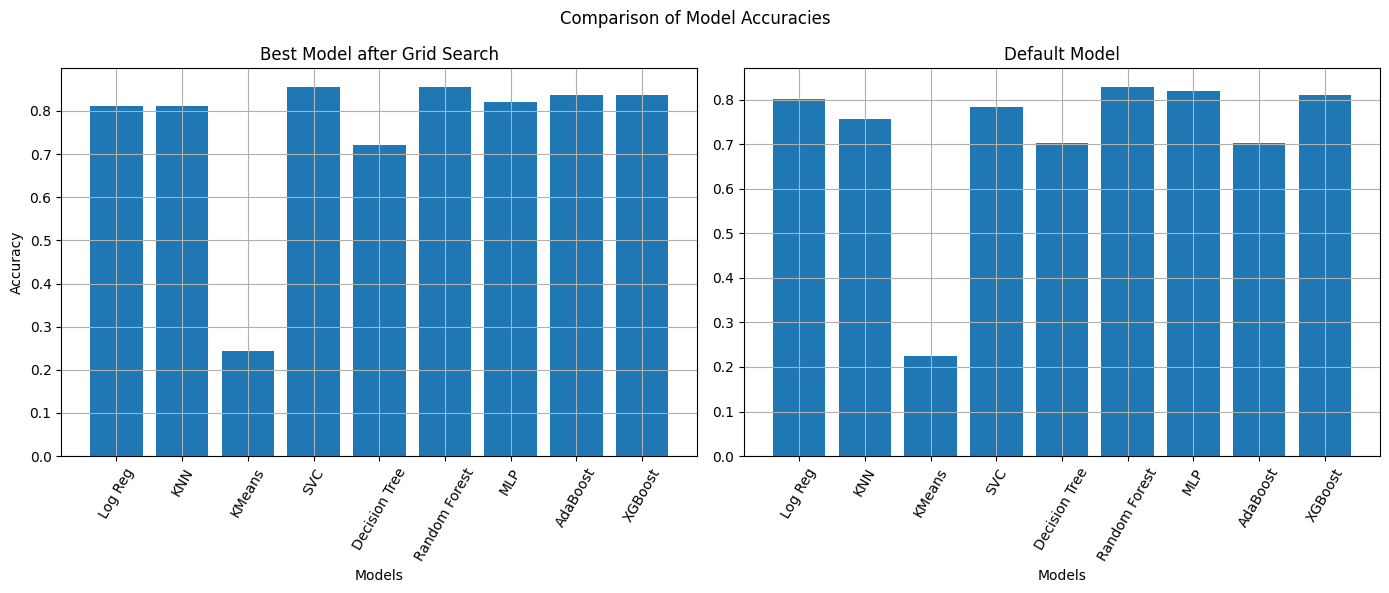

In [34]:
print(f"Models: {model_type}")
print(f"Accuracies after Model Grid Search: {score_accuracy}")
print(f"Accuracies with Default Model: {score_accuracy_default}")

categories = model_type
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].bar(categories, score_accuracy)
axes[0].set_title('Best Model after Grid Search')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=60) 
axes[0].grid()
axes[1].bar(categories, score_accuracy_default)
axes[1].set_title('Default Model')
axes[1].set_xlabel('Models')
axes[1].tick_params(axis='x', rotation=60) 
axes[1].grid()
plt.suptitle('Comparison of Model Accuracies')
plt.tight_layout()
plt.show()

### Neural Network Analysis

In [35]:
run_cnn = False

In [36]:
if run_cnn:
    def build_deep_cnn(input_shape=(128, 64, 8), num_classes=7):
        inputs = Input(shape=input_shape)
        
        x = Conv2D(64, (3, 3), padding='same', strides=1)(inputs)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D((2, 2))(x)

        x = Conv2D(128, (3, 3), padding='same', strides=1)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D((2, 2))(x)  

        x = Conv2D(256, (3, 3), padding='same', strides=1)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D((2, 2))(x)
        
        x = Conv2D(512, (3, 3), padding='same', strides=1)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D((2, 2))(x)

        x = Conv2D(1024, (3, 3), padding='same', strides=1)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D((2, 2))(x)
        x = GlobalAveragePooling2D()(x)  

        x = Dense(512, activation='relu')(x)
        x = Dropout(0.5)(x)
        
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        
        outputs = Dense(num_classes, activation='softmax')(x)
        model = Model(inputs=inputs, outputs=outputs)
        return model

    num_classes = 7
    input_shape = (128, 64, 8)
    cnn_model = build_deep_cnn(input_shape, num_classes)
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    cnn_model.summary()

    history = cnn_model.fit(X_cnn_train, y_oh_cnn_train, epochs=200, batch_size=32)
    test_loss, test_acc = cnn_model.evaluate(X_cnn_test, y_oh_cnn_test)
    print(f"Test Accuracy: {test_acc * 100:.2f}%")

### Model Analysis and Evaluation

In [37]:
def visualize_classification_metrics(model, X_test, y_test, class_names=None):
    y_pred = model.predict(X_test)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

In [39]:
if run_cnn:
    y_pred = cnn_model.predict(X_cnn_test)

    y_pred_categorical = np.argmax(y_pred, axis=1)
    y_true_categorical = np.argmax(y_oh_cnn_test, axis=1)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true_categorical, y_pred_categorical)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'], yticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'])
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true_categorical, y_pred_categorical, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'], zero_division=0))

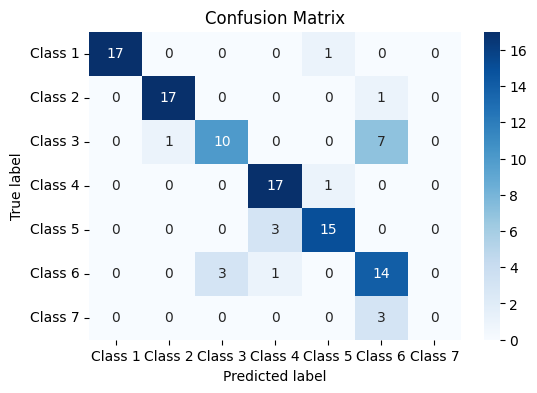

Classification Report:
              precision    recall  f1-score   support

     Class 1       1.00      0.94      0.97        18
     Class 2       0.94      0.94      0.94        18
     Class 3       0.77      0.56      0.65        18
     Class 4       0.81      0.94      0.87        18
     Class 5       0.88      0.83      0.86        18
     Class 6       0.56      0.78      0.65        18
     Class 7       0.00      0.00      0.00         3

    accuracy                           0.81       111
   macro avg       0.71      0.71      0.71       111
weighted avg       0.81      0.81      0.80       111



In [40]:
visualize_classification_metrics(log_reg, X_test, y_test, ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'])

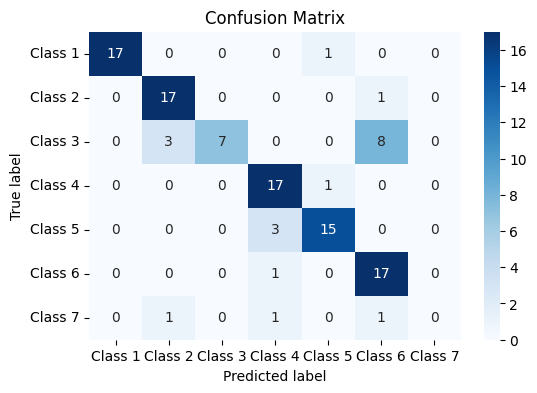

Classification Report:
              precision    recall  f1-score   support

     Class 1       1.00      0.94      0.97        18
     Class 2       0.81      0.94      0.87        18
     Class 3       1.00      0.39      0.56        18
     Class 4       0.77      0.94      0.85        18
     Class 5       0.88      0.83      0.86        18
     Class 6       0.63      0.94      0.76        18
     Class 7       0.00      0.00      0.00         3

    accuracy                           0.81       111
   macro avg       0.73      0.71      0.70       111
weighted avg       0.83      0.81      0.79       111



In [41]:
visualize_classification_metrics(knn, X_test, y_test, ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'])

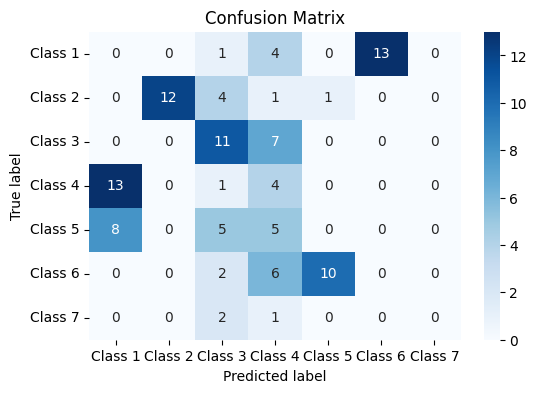

Classification Report:
              precision    recall  f1-score   support

     Class 1       0.00      0.00      0.00        18
     Class 2       1.00      0.67      0.80        18
     Class 3       0.42      0.61      0.50        18
     Class 4       0.14      0.22      0.17        18
     Class 5       0.00      0.00      0.00        18
     Class 6       0.00      0.00      0.00        18
     Class 7       0.00      0.00      0.00         3

    accuracy                           0.24       111
   macro avg       0.22      0.21      0.21       111
weighted avg       0.25      0.24      0.24       111



In [42]:
visualize_classification_metrics(kmeans, X_test, y_test, ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'])

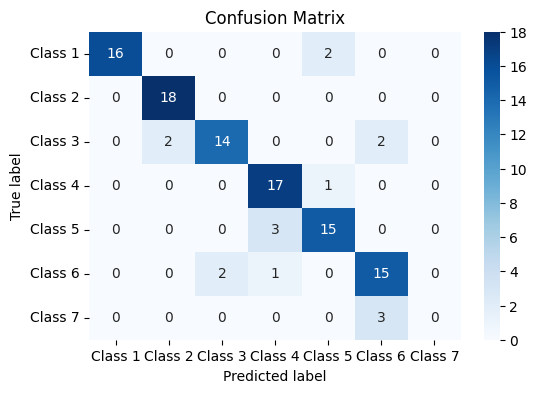

Classification Report:
              precision    recall  f1-score   support

     Class 1       1.00      0.89      0.94        18
     Class 2       0.90      1.00      0.95        18
     Class 3       0.88      0.78      0.82        18
     Class 4       0.81      0.94      0.87        18
     Class 5       0.83      0.83      0.83        18
     Class 6       0.75      0.83      0.79        18
     Class 7       0.00      0.00      0.00         3

    accuracy                           0.86       111
   macro avg       0.74      0.75      0.74       111
weighted avg       0.84      0.86      0.84       111



In [43]:
visualize_classification_metrics(svc, X_test, y_test, ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'])

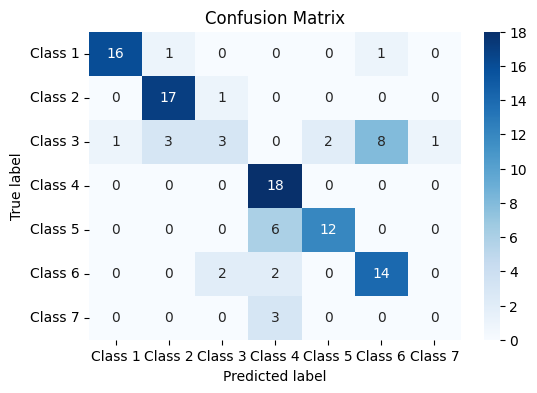

Classification Report:
              precision    recall  f1-score   support

     Class 1       0.94      0.89      0.91        18
     Class 2       0.81      0.94      0.87        18
     Class 3       0.50      0.17      0.25        18
     Class 4       0.62      1.00      0.77        18
     Class 5       0.86      0.67      0.75        18
     Class 6       0.61      0.78      0.68        18
     Class 7       0.00      0.00      0.00         3

    accuracy                           0.72       111
   macro avg       0.62      0.63      0.60       111
weighted avg       0.70      0.72      0.69       111



In [44]:
visualize_classification_metrics(dtc, X_test, y_test, ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'])

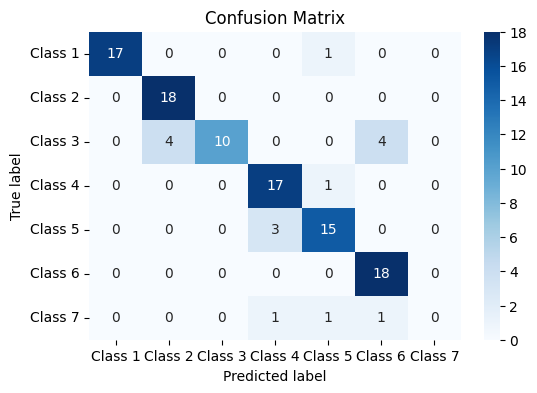

Classification Report:
              precision    recall  f1-score   support

     Class 1       1.00      0.94      0.97        18
     Class 2       0.82      1.00      0.90        18
     Class 3       1.00      0.56      0.71        18
     Class 4       0.81      0.94      0.87        18
     Class 5       0.83      0.83      0.83        18
     Class 6       0.78      1.00      0.88        18
     Class 7       0.00      0.00      0.00         3

    accuracy                           0.86       111
   macro avg       0.75      0.75      0.74       111
weighted avg       0.85      0.86      0.84       111



In [45]:
visualize_classification_metrics(rf, X_test, y_test, ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'])

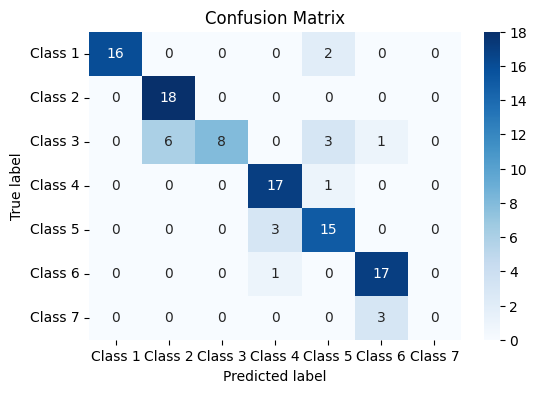

Classification Report:
              precision    recall  f1-score   support

     Class 1       1.00      0.89      0.94        18
     Class 2       0.75      1.00      0.86        18
     Class 3       1.00      0.44      0.62        18
     Class 4       0.81      0.94      0.87        18
     Class 5       0.71      0.83      0.77        18
     Class 6       0.81      0.94      0.87        18
     Class 7       0.00      0.00      0.00         3

    accuracy                           0.82       111
   macro avg       0.73      0.72      0.70       111
weighted avg       0.82      0.82      0.80       111



In [46]:
visualize_classification_metrics(mlp, X_test, y_test, ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'])

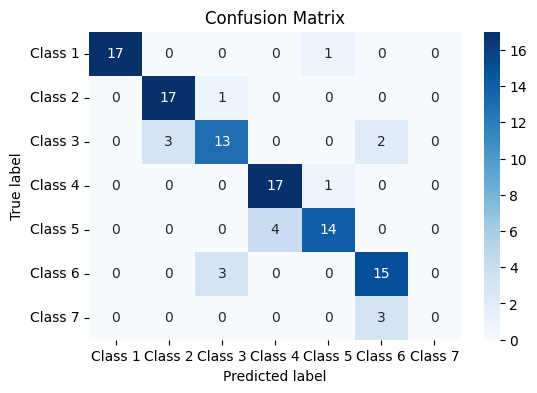

Classification Report:
              precision    recall  f1-score   support

     Class 1       1.00      0.94      0.97        18
     Class 2       0.85      0.94      0.89        18
     Class 3       0.76      0.72      0.74        18
     Class 4       0.81      0.94      0.87        18
     Class 5       0.88      0.78      0.82        18
     Class 6       0.75      0.83      0.79        18
     Class 7       0.00      0.00      0.00         3

    accuracy                           0.84       111
   macro avg       0.72      0.74      0.73       111
weighted avg       0.82      0.84      0.83       111



In [47]:
visualize_classification_metrics(xgb, X_test, y_xgb_test, ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'])

Class 3 often gets misclassified as Class 5 and Class 6

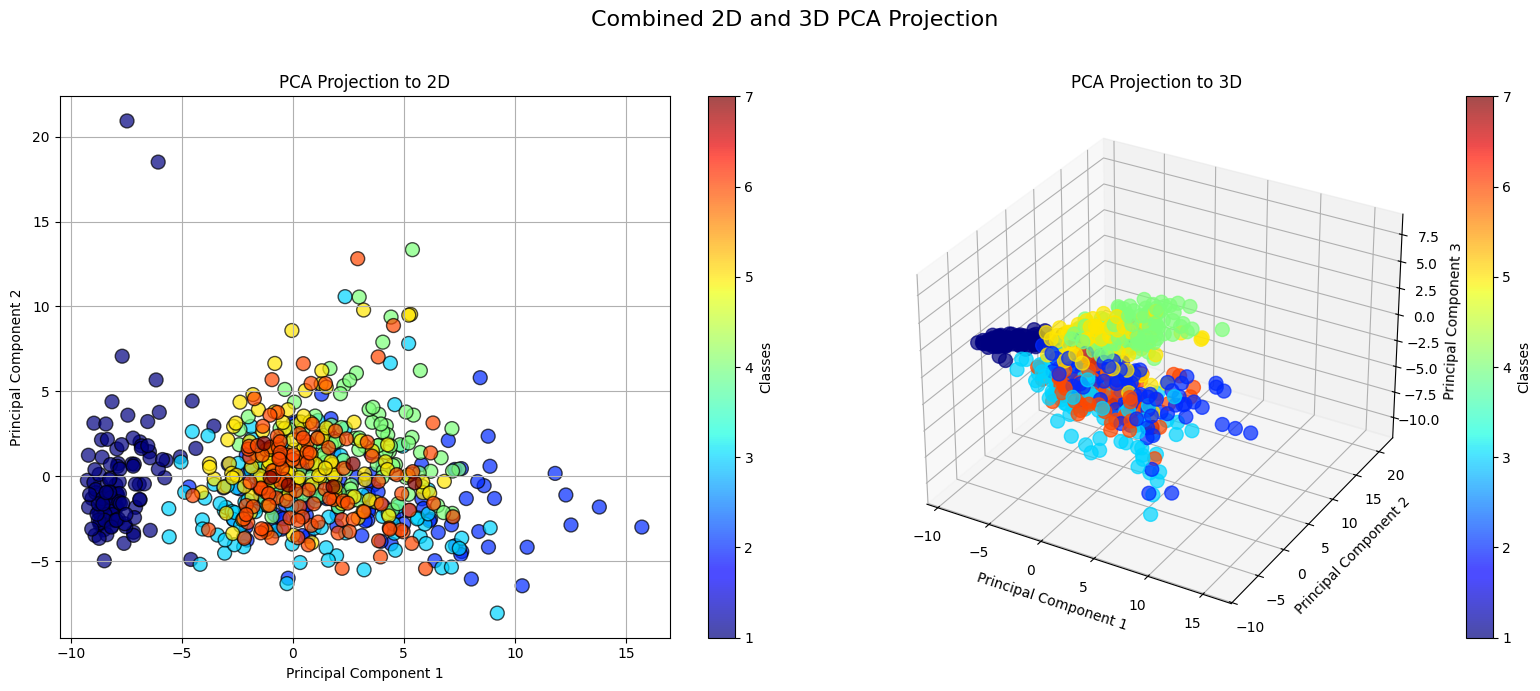

In [48]:
# PCA on entire dataset
X_scale = StandardScaler().fit_transform(X)
X_pca2d = PCA(n_components=2).fit_transform(X_scale)
X_pca3d = PCA(n_components=3).fit_transform(X_scale)
fig = plt.figure(figsize=(16, 7))

ax1 = fig.add_subplot(121)
scatter2d = ax1.scatter(X_pca2d[:, 0], X_pca2d[:, 1], c=y, cmap='jet', edgecolor='k', s=100, alpha=0.7)
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_title('PCA Projection to 2D')
ax1.grid()
cbar = plt.colorbar(scatter2d, ax=ax1)
cbar.set_label('Classes')

ax2 = fig.add_subplot(122, projection='3d')
scatter3d = ax2.scatter(X_pca3d[:, 0], X_pca3d[:, 1], X_pca3d[:, 2], c=y, cmap='jet', s=100, alpha=0.7)
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_zlabel('Principal Component 3')
ax2.set_title('PCA Projection to 3D')
cbar3d = plt.colorbar(scatter3d, ax=ax2)
cbar3d.set_label('Classes')
plt.suptitle('Combined 2D and 3D PCA Projection', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

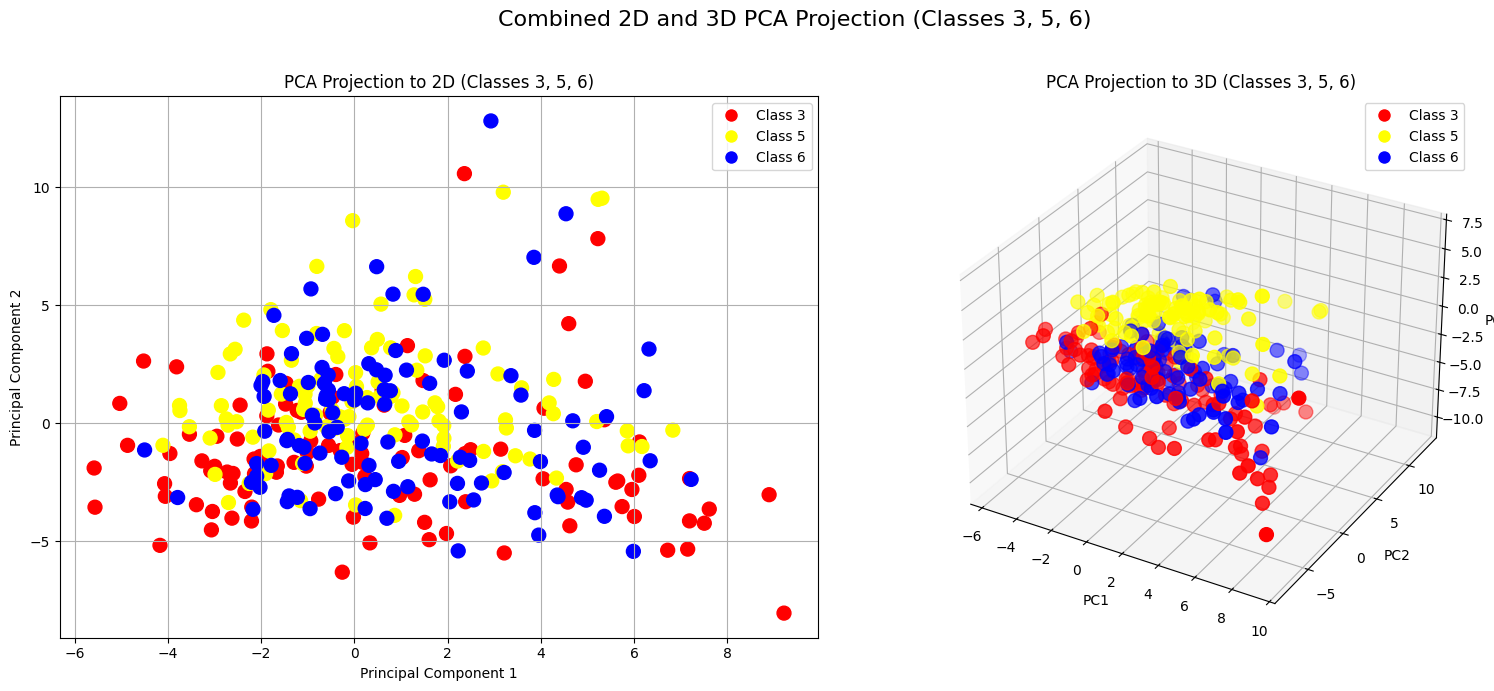

In [49]:
y_mapped = np.hstack((np.where(y == 3), np.where(y == 5), np.where(y == 6)))
X_filtered_2d = X_pca2d[y_mapped][0]
X_filtered_3d = X_pca3d[y_mapped][0]
y_filtered = y[y_mapped][0]

colors = {3: 'red', 5: 'yellow', 6: 'blue'}
color_list = [colors[label] for label in y_filtered]
fig = plt.figure(figsize=(16, 7))

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Class 3', markerfacecolor='red', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='Class 5', markerfacecolor='yellow', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='Class 6', markerfacecolor='blue', markersize=10)]

ax1 = fig.add_subplot(121)
scatter2d = ax1.scatter(X_filtered_2d[:, 0], X_filtered_2d[:, 1], c=color_list, s=100)
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_title('PCA Projection to 2D (Classes 3, 5, 6)')
ax1.legend(handles=legend_elements, loc='best')
ax1.grid()

ax2 = fig.add_subplot(122, projection='3d')
scatter3d = ax2.scatter(X_filtered_3d[:, 0], X_filtered_3d[:, 1], X_filtered_3d[:, 2], c=color_list, s=100)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.set_title('PCA Projection to 3D (Classes 3, 5, 6)')
ax2.legend(handles=legend_elements, loc='best')

plt.suptitle('Combined 2D and 3D PCA Projection (Classes 3, 5, 6)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Ensemble Model Training

In [50]:
from sklearn.ensemble import VotingClassifier

In [51]:
y_train = [int(label-1) for label in y_train]
y_test = [int(label-1) for label in y_test]

custom_weights = {0: 1.0, 1: 1.0, 2: 20.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}
svc = SVC(probability=True, C=10, kernel='rbf', gamma=0.001, shrinking=True, tol=0.01, class_weight=custom_weights, decision_function_shape='ovr', random_state=42)

custom_weights = {0: 1.0, 1: 1.0, 2: 15.0, 3: 1.0, 4: 5.0, 5: 1.0, 6: 1.0}
rf = RandomForestClassifier(bootstrap=True, n_estimators=300, criterion='entropy', class_weight=custom_weights, ccp_alpha=0.0, max_depth=10, max_features='log2', min_samples_leaf=1, min_samples_split=2, random_state=42)

xgb = XGBClassifier(n_estimators=200, colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=1, reg_alpha=0.1, reg_lambda=2, subsample=0.6, random_state=42)

ensemble_model = VotingClassifier(estimators=[('svc', svc), ('rf', rf), ('xgb', xgb)], voting='hard')
ensemble_model.fit(X_train, y_train)
y_pred = ensemble_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Ensemble Model Accuracy:", accuracy)

Ensemble Model Accuracy: 0.8738738738738738


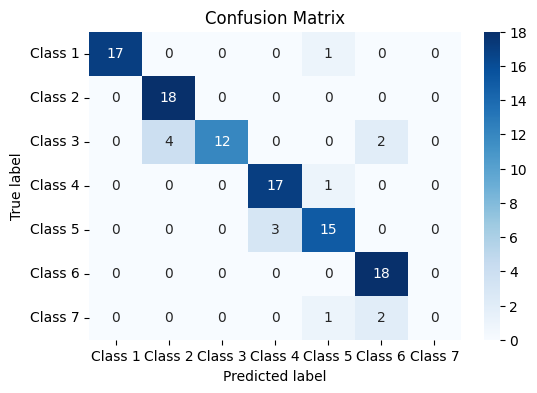

Classification Report:
              precision    recall  f1-score   support

     Class 1       1.00      0.94      0.97        18
     Class 2       0.82      1.00      0.90        18
     Class 3       1.00      0.67      0.80        18
     Class 4       0.85      0.94      0.89        18
     Class 5       0.83      0.83      0.83        18
     Class 6       0.82      1.00      0.90        18
     Class 7       0.00      0.00      0.00         3

    accuracy                           0.87       111
   macro avg       0.76      0.77      0.76       111
weighted avg       0.86      0.87      0.86       111



In [52]:
visualize_classification_metrics(ensemble_model, X_test, y_test, ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7'])